In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    silhouette_score, davies_bouldin_score, adjusted_rand_score,
    classification_report
)
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

RANDOM_STATE = 42


#IRIS DATASET

In [2]:
df = pd.read_csv("Iris.csv")
df.head()


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
print("Shape:", df.shape)

print("\nInfo:")
df.info()

print("\nSpecies counts:")
print(df["Species"].value_counts())


Shape: (150, 6)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB

Species counts:
Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [4]:
features = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
df[features].describe()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


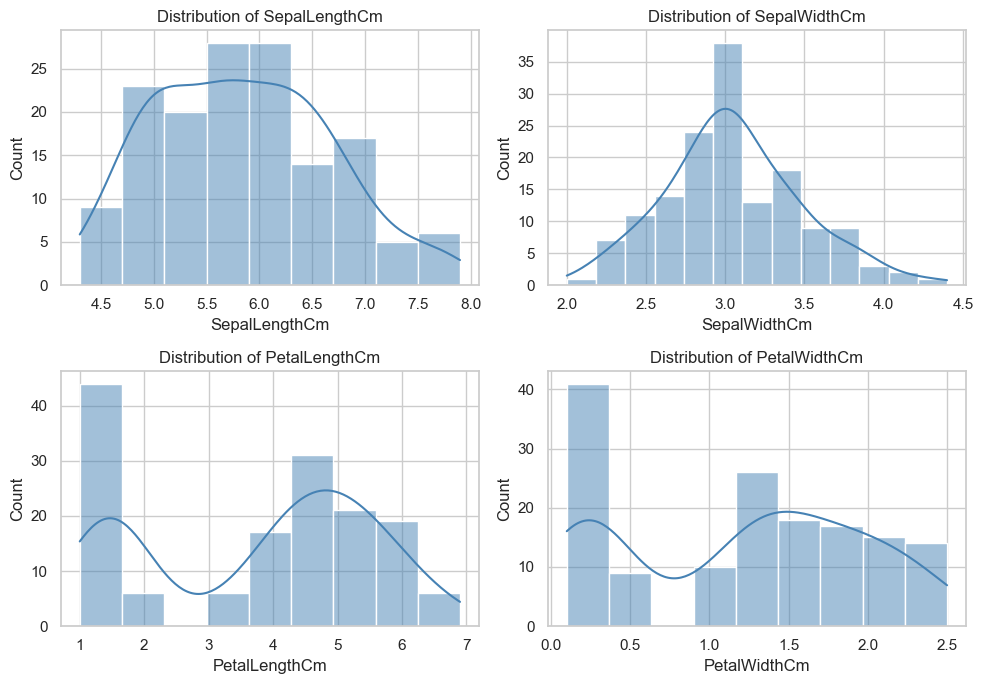

In [5]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
for ax, col in zip(axes.ravel(), features):
    sns.histplot(df[col], kde=True, ax=ax, color="steelblue")
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


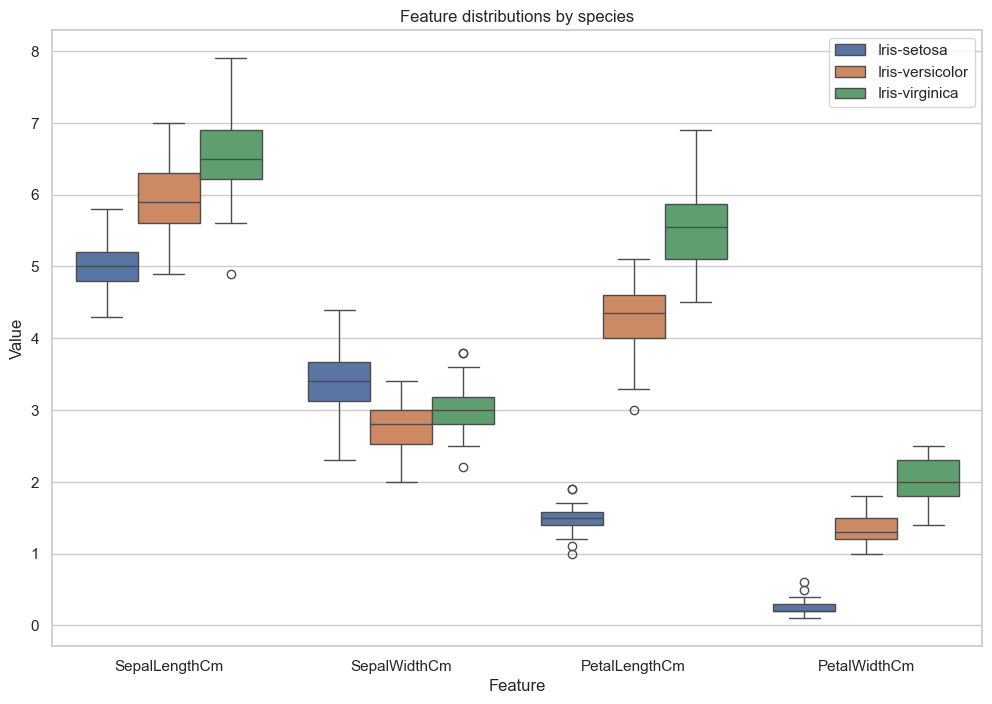

In [6]:
plt.figure(figsize=(12, 8))

melted = df.melt(
    id_vars="Species",
    value_vars=features,
    var_name="Feature",
    value_name="Value"
)

sns.boxplot(data=melted, x="Feature", y="Value", hue="Species")
plt.title("Feature distributions by species")
plt.legend(loc="best")
plt.show()


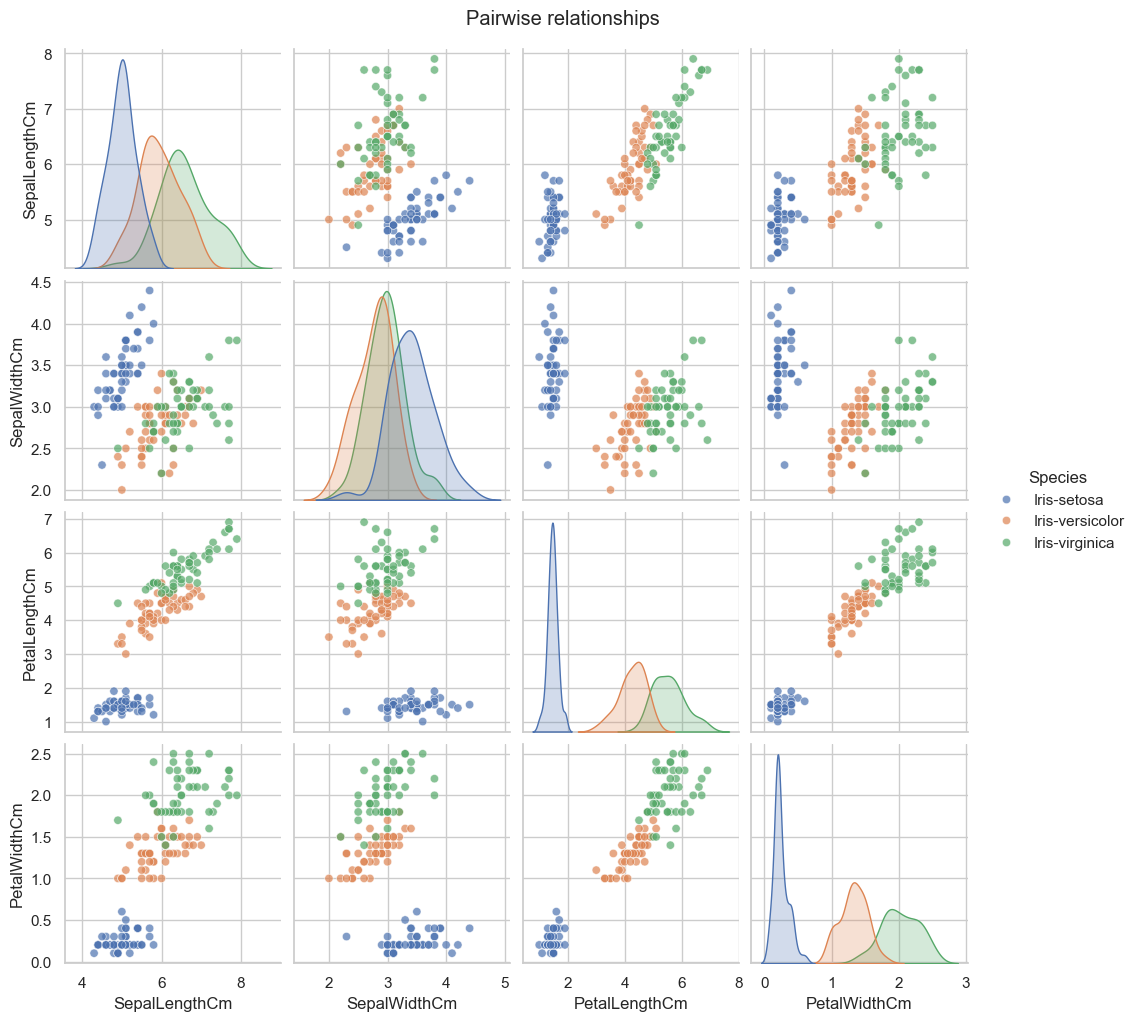

In [7]:
sns.pairplot(
    df,
    hue="Species",
    vars=features,
    diag_kind="kde",
    plot_kws={"alpha": 0.7}
)

plt.suptitle("Pairwise relationships", y=1.02)
plt.show()


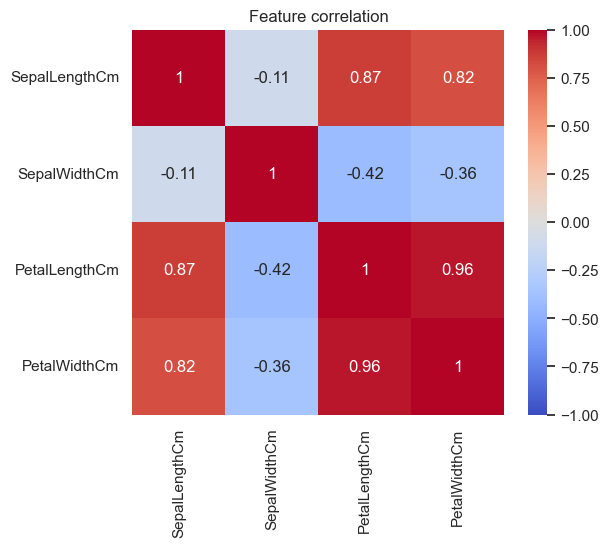

In [8]:
plt.figure(figsize=(6, 5))

corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Feature correlation")
plt.show()


#LOAN APPROVAL DATASET

In [2]:
df = pd.read_csv("loan_train.csv")
df.head()


,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [3]:
print("Shape:", df.shape)

print("\nInfo:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())


Shape: (30000, 24)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  30000 non-null  object 
 1   Name                         30000 non-null  object 
 2   Gender                       29947 non-null  object 
 3   Age                          30000 non-null  int64  
 4   Income (USD)                 25424 non-null  float64
 5   Income Stability             28317 non-null  object 
 6   Profession                   30000 non-null  object 
 7   Type of Employment           22730 non-null  object 
 8   Location                     30000 non-null  object 
 9   Loan Amount Request (USD)    30000 non-null  float64
 10  Current Loan Expenses (USD)  29828 non-null  float64
 11  Expense Type 1               30000 non-null  object 
 12  Expense Type 2               30000 non-null  obj

In [4]:
df.describe(include="all")


,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,30000,30000,29947,30000.000000,2.542400e+04,28317,30000,22730,30000,30000.000000,...,28297.000000,30000.000000,28434,30000.000000,2.515000e+04,30000.000000,29644,30000.000000,3.000000e+04,29660.000000
unique,30000,30000,2,NaN,NaN,2,8,18,3,NaN,...,NaN,NaN,3,NaN,NaN,NaN,3,NaN,NaN,NaN
top,C-36995,Frederica Shealy,M,NaN,NaN,Low,Working,Laborers,Semi-Urban,NaN,...,NaN,NaN,Active,NaN,NaN,NaN,Semi-Urban,NaN,NaN,NaN
freq,1,1,15053,NaN,NaN,25751,16926,5578,21563,NaN,...,NaN,NaN,9771,NaN,NaN,NaN,10387,NaN,NaN,NaN
mean,NaN,NaN,NaN,40.092300,2.630574e+03,NaN,NaN,NaN,NaN,88826.333855,...,739.885381,0.193933,NaN,501.934700,2.631119e+03,2.460067,NaN,-4.743867,1.317597e+05,47649.342208
std,NaN,NaN,NaN,16.045129,1.126272e+04,NaN,NaN,NaN,NaN,59536.949605,...,72.163846,0.395384,NaN,288.158086,1.132268e+04,1.118562,NaN,74.614593,9.354955e+04,48221.146686
min,NaN,NaN,NaN,18.000000,3.777000e+02,NaN,NaN,NaN,NaN,6048.240000,...,580.000000,0.000000,NaN,1.000000,3.777000e+02,1.000000,NaN,-999.000000,-9.990000e+02,-999.000000
25%,NaN,NaN,NaN,25.000000,1.650457e+03,NaN,NaN,NaN,NaN,41177.755000,...,681.880000,0.000000,NaN,251.000000,1.650450e+03,1.000000,NaN,1.000000,6.057216e+04,0.000000
50%,NaN,NaN,NaN,40.000000,2.222435e+03,NaN,NaN,NaN,NaN,75128.075000,...,739.820000,0.000000,NaN,504.000000,2.223250e+03,2.000000,NaN,1.000000,1.099936e+05,35209.395000
75%,NaN,NaN,NaN,55.000000,3.090593e+03,NaN,NaN,NaN,NaN,119964.605000,...,799.120000,0.000000,NaN,751.000000,3.091408e+03,3.000000,NaN,1.000000,1.788807e+05,74261.250000


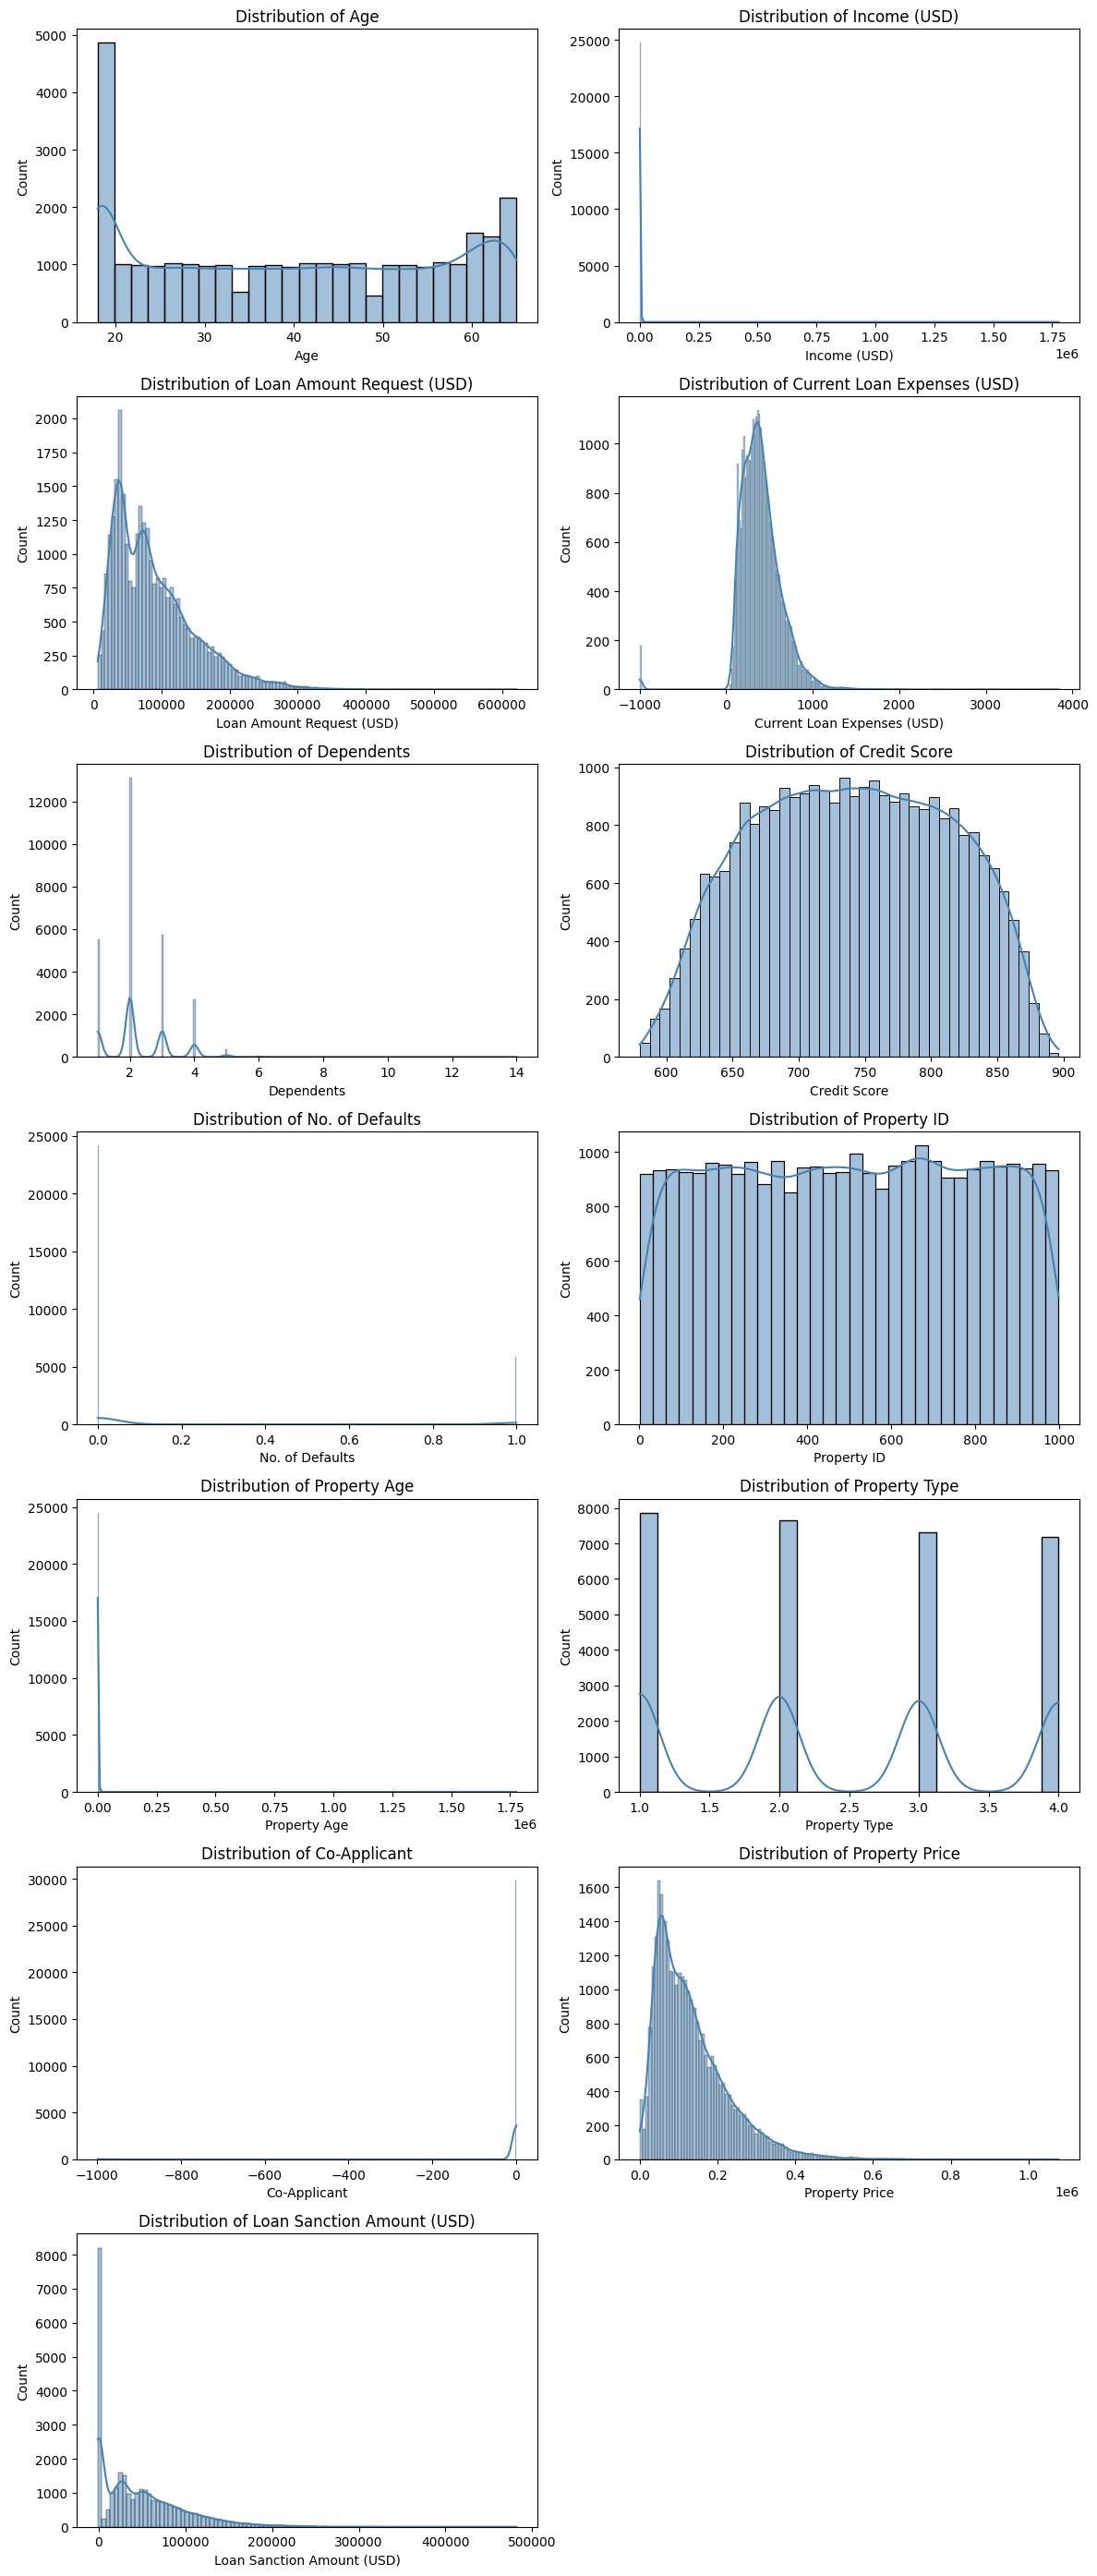

In [5]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

n_cols = 2
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"Distribution of {col}")

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [6]:
if "Loan_Status" in df.columns:
    plt.figure(figsize=(12, 8))

    melted = df.melt(
        id_vars="Loan_Status",
        value_vars=numeric_cols,
        var_name="Feature",
        value_name="Value"
    )

    sns.boxplot(data=melted, x="Feature", y="Value", hue="Loan_Status")
    plt.title("Feature distributions by Loan Status")
    plt.xticks(rotation=45)
    plt.show()


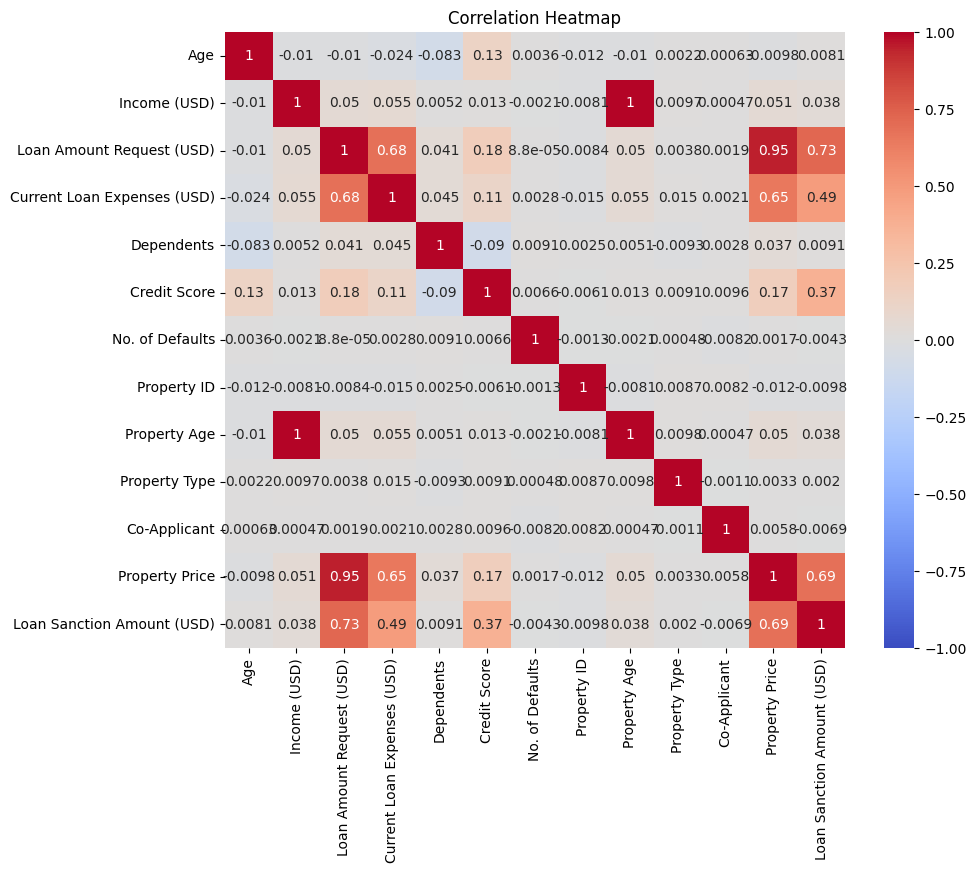

In [7]:
plt.figure(figsize=(10, 8))

corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()


#DIABETES DATASET

In [8]:
df = pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
print("Shape:", df.shape)

print("\nInfo:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())


Shape: (768, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesP

In [10]:
df.describe(include="all")


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


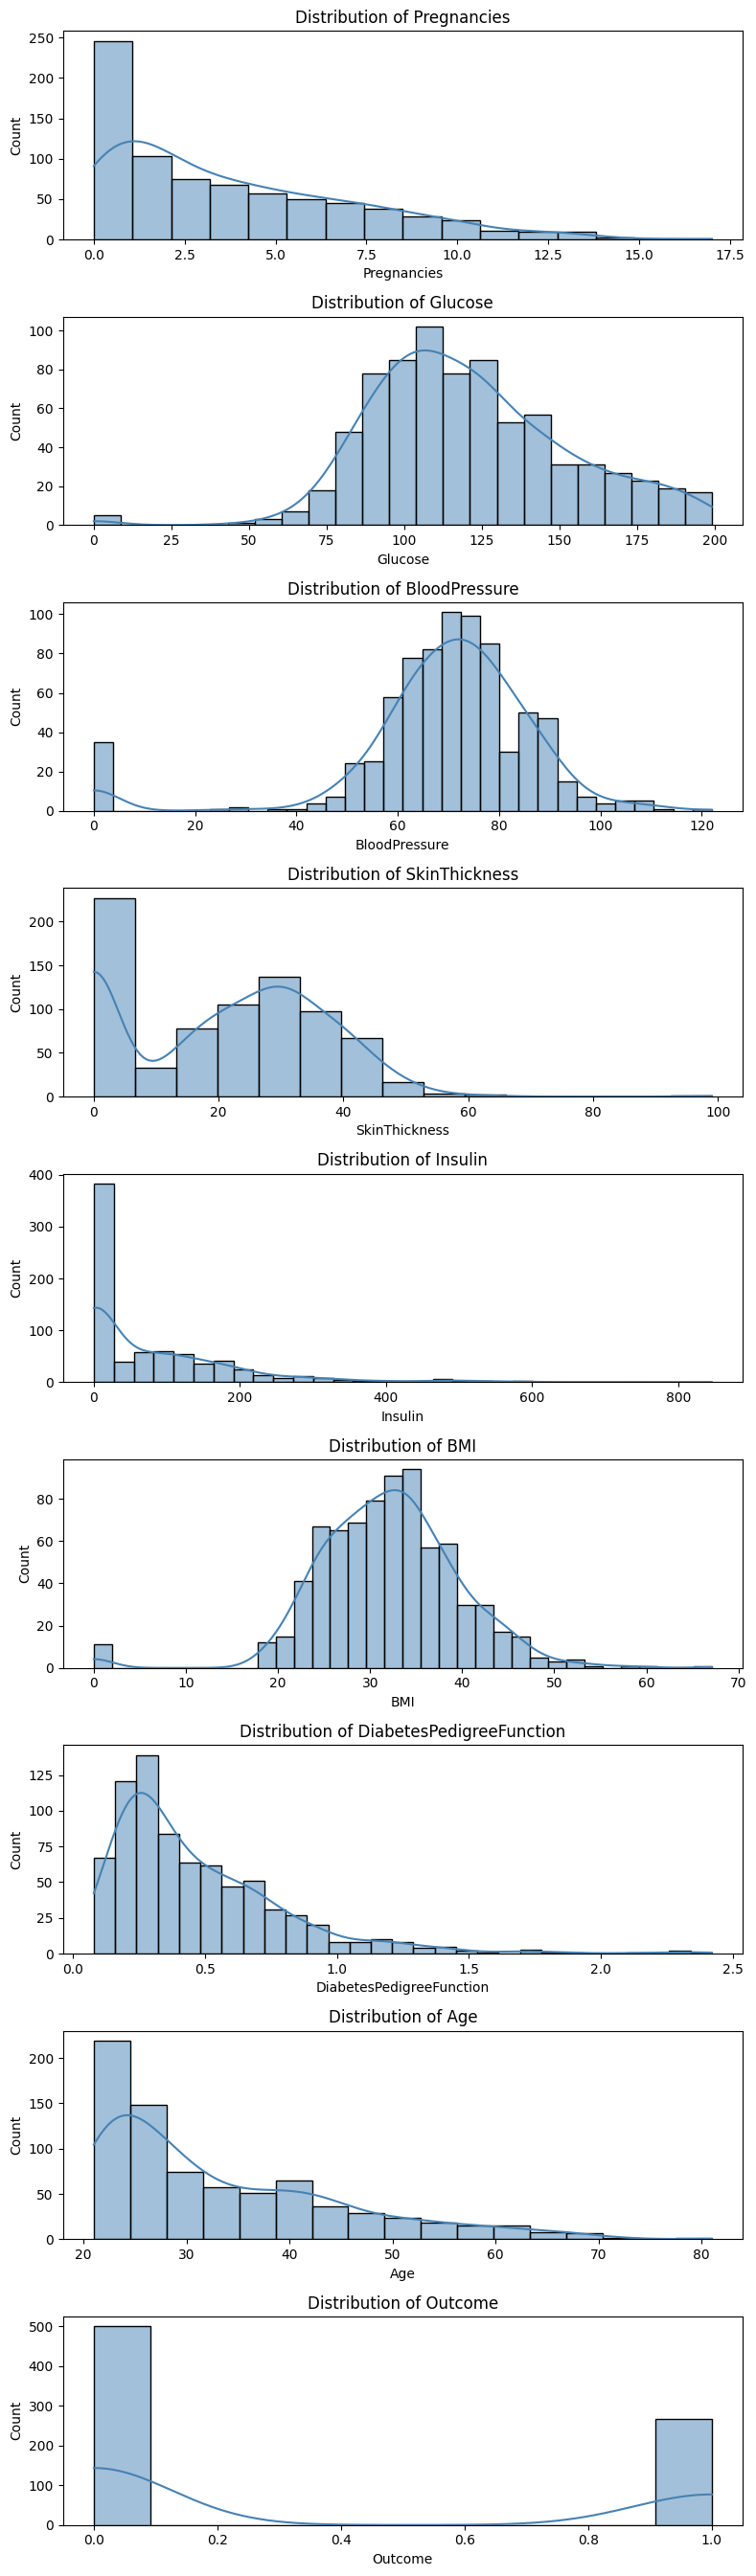

In [11]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(8, 3*len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


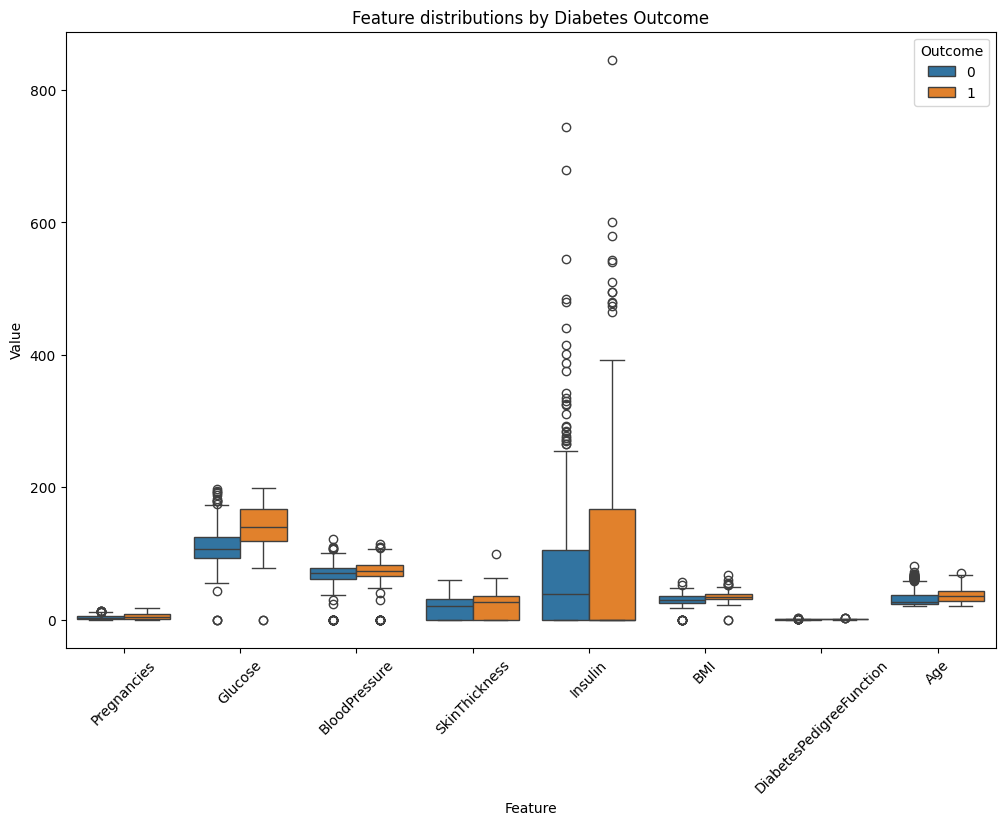

In [12]:
if "Outcome" in df.columns:
    plt.figure(figsize=(12, 8))

    melted = df.melt(
        id_vars="Outcome",
        value_vars=numeric_cols,
        var_name="Feature",
        value_name="Value"
    )

    sns.boxplot(data=melted, x="Feature", y="Value", hue="Outcome")
    plt.title("Feature distributions by Diabetes Outcome")
    plt.xticks(rotation=45)
    plt.show()


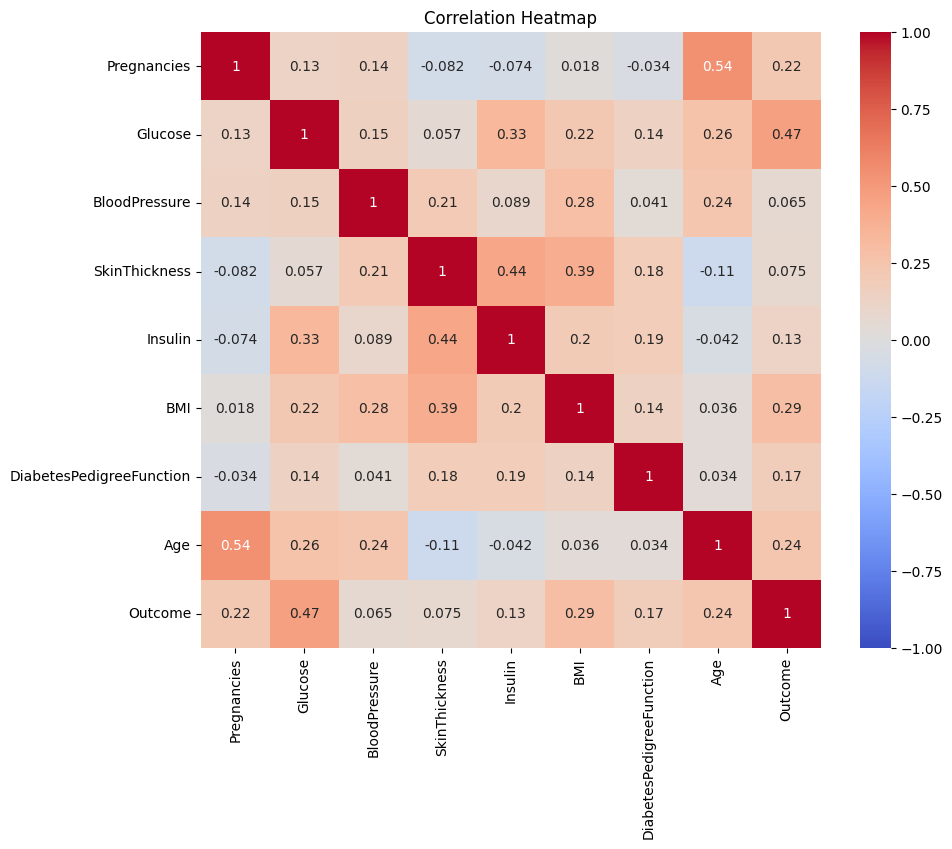

In [13]:
plt.figure(figsize=(10, 8))

corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Correlation Heatmap")
plt.show()


In [14]:
categorical_cols = df.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue="Outcome" if "Outcome" in df.columns else None)
    plt.title(f"Counts of {col}")
    plt.xticks(rotation=45)
    plt.show()


#EMAIL CLASSIFICATION

In [15]:
df = pd.read_csv("email.csv")
df.head()


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
print("Shape:", df.shape)
df.info()

print("\nMissing values:")
print(df.isnull().sum())


Shape: (5572, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Missing values:
Category    0
Message     0
dtype: int64


In [17]:
df.describe(include="all")


,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [18]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

if len(numeric_cols) > 0:
    rows = math.ceil(len(numeric_cols)/2)
    fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))
    axes = axes.ravel()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], kde=True, ax=axes[i], color="steelblue")
        axes[i].set_title(f"Distribution of {col}")

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [19]:
if len(numeric_cols) > 0:
    plt.figure(figsize=(10, 8))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")
    plt.show()


#HANDWRITING RECOGNITION

In [22]:
df = pd.read_csv("english.csv")
df.head()


,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [23]:
print("Shape:", df.shape)
df.info()

print("\nMissing values:")
print(df.isnull().sum())


Shape: (3410, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3410 non-null   object
 1   label   3410 non-null   object
dtypes: object(2)
memory usage: 53.4+ KB

Missing values:
image    0
label    0
dtype: int64


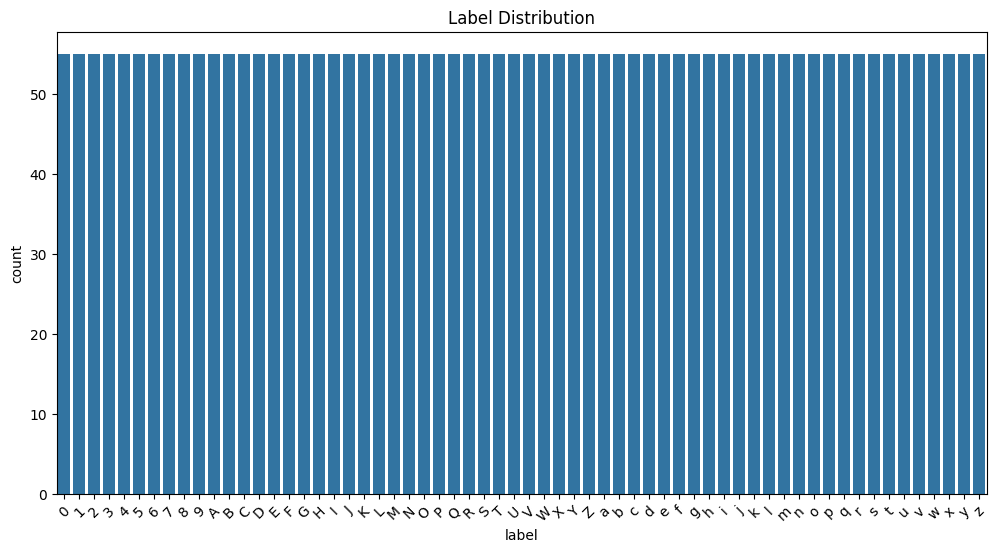

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index)
plt.title("Label Distribution")
plt.xticks(rotation=45)
plt.show()


In [25]:
def show_samples(df, labels, samples_per_label=5):
    fig, axes = plt.subplots(
        len(labels), samples_per_label,
        figsize=(samples_per_label*2, len(labels)*2)
    )

    for i, label in enumerate(labels):
        subset = df[df["label"] == label].sample(samples_per_label, random_state=42)
        for j, img_path in enumerate(subset["image"].values):
            path = "handwritten/" + img_path
            if os.path.exists(path):
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                axes[i, j].imshow(img, cmap="gray")
                axes[i, j].axis("off")
                axes[i, j].set_title(str(label))
            else:
                axes[i, j].text(0.5, 0.5, "Missing", ha="center", va="center")
                axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()


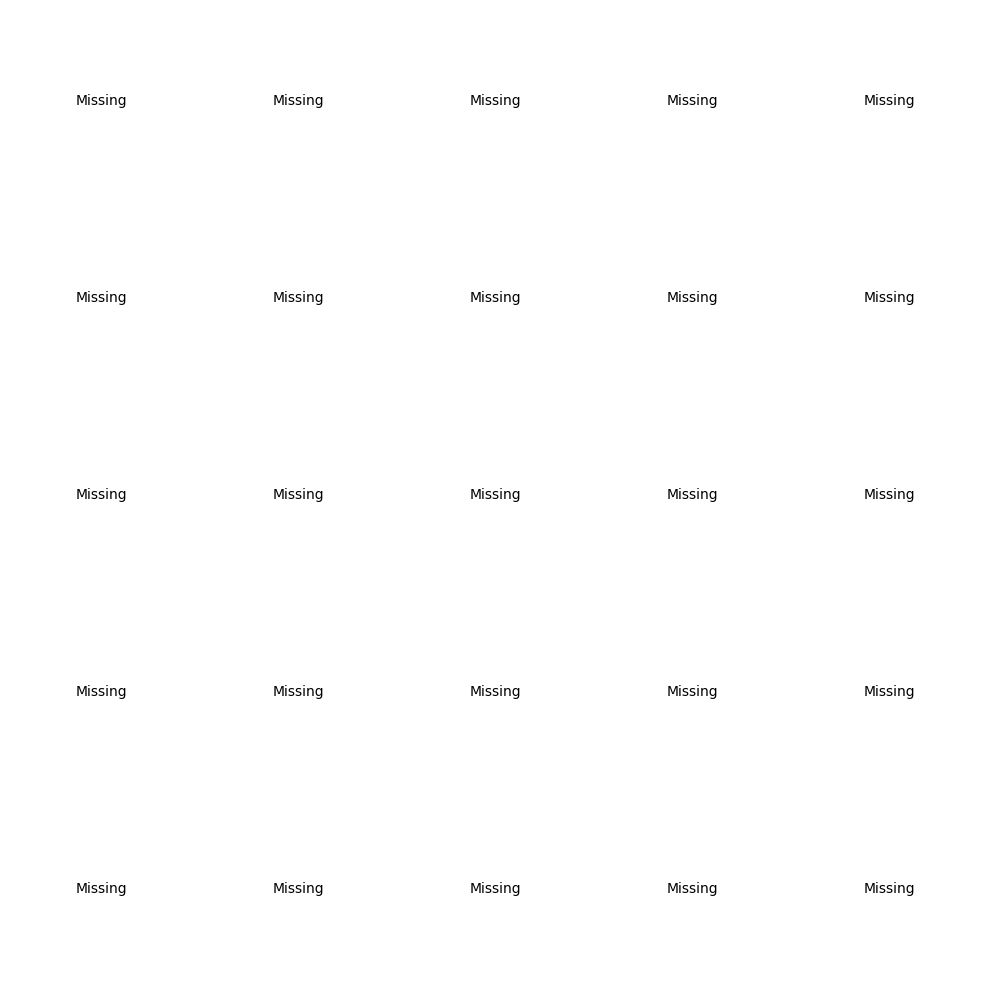

In [26]:
unique_labels = df["label"].unique()
show_samples(df, unique_labels[:5], samples_per_label=5)


C:\Users\Sabarithan P\AppData\Local\Temp\ipykernel_1392\2171688439.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


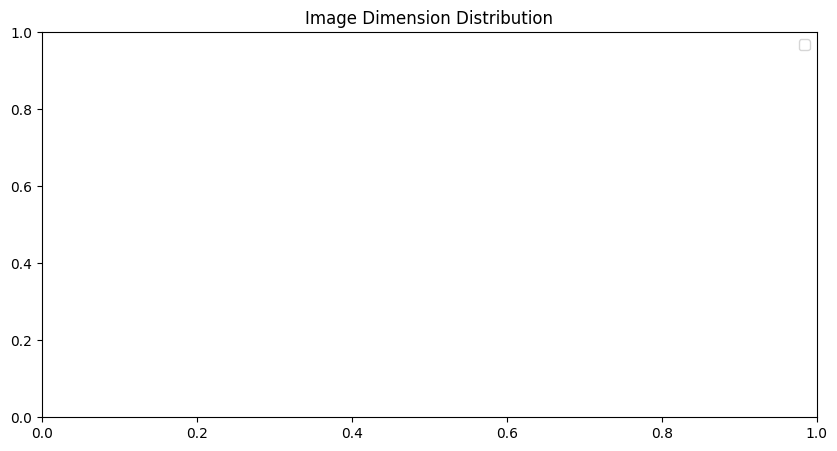

In [29]:
heights, widths = [], []

for img_path in df["image"].sample(min(200, len(df)), random_state=42):
    path = "handwritten/" + img_path
    if os.path.exists(path):
        img = cv2.imread(path)
        if img is not None:
            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)

plt.figure(figsize=(10, 5))

ax = sns.histplot(heights, kde=True, color="steelblue", label="Heights")
sns.histplot(widths, kde=True, color="orange", label="Widths", ax=ax)

ax.legend()
ax.set_title("Image Dimension Distribution")

plt.show()
